In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')

labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

In [3]:
normalize = MinMaxScaler() # choose transform
normalize.fit(df_train); # fit transform
df_train_normalized = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
df_test_normalized = np.single(normalize.transform(df_test))

In [4]:
X_train = df_train_normalized.reshape(-1,28*28,)
X_test = df_test_normalized.reshape(-1,28*28,)

In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [6]:
original_dim = 28*28
intermediate_dim = 196
latent_dim = 6

In [8]:
inputs = tf.keras.Input(shape=(original_dim,))
h = Reshape((28,28,1))(inputs)
h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
h = MaxPooling2D((2,2))(h)
h = Conv2D(16, (3,3), activation='relu', padding='same')(h)
h = MaxPooling2D((2,2))(h)
h = Flatten()(h)
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(h)
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)
Model(inputs, h).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0   

In [10]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

In [13]:
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(784)(x)
x = Reshape((7,7,16))(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
x = Conv2DTranspose(1, (3,3), activation='relu', padding='same')(x)
x = Flatten()(x)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

In [14]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.30)
batch_size=32
vae.fit(X_train, X_train,
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        validation_data=(X_test, X_test))

Epoch 1/50
1875/1875 [==============================] - 20s 11ms/step - loss: 224.6626 - val_loss: 225.1025
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 224.4642 - val_loss: 224.5055
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 224.2750 - val_loss: 224.5068
Epoch 4/50
1875/1875 [==============================] - 20s 10ms/step - loss: 224.1205 - val_loss: 224.4517
Epoch 5/50
1875/1875 [==============================] - 19s 10ms/step - loss: 223.9908 - val_loss: 224.7668
Epoch 6/50
1875/1875 [==============================] - 19s 10ms/step - loss: 223.8747 - val_loss: 224.0011
Epoch 7/50
1875/1875 [==============================] - 18s 10ms/step - loss: 223.7241 - val_loss: 223.9740
Epoch 8/50
1875/1875 [==============================] - 18s 10ms/step - loss: 223.6424 - val_loss: 223.7494
Epoch 9/50
1875/1875 [==============================] - 18s 10ms/step - loss: 223.5567 - val_loss: 224.1224
Epoch 10/50
1875/1875 [=====

KeyboardInterrupt: 

In [18]:
# save model
save_filepath = 'model/fmnist_vae/last'
vae.save(
    filepath=save_filepath,
    overwrite=True,
    include_optimizer=True,
)
# load model
loaded_model = tf.keras.models.load_model(save_filepath)

INFO:tensorflow:Assets written to: model/fmnist_vae/last\assets


SystemError: unknown opcode

In [19]:
import matplotlib.pyplot as plt

In [25]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
X_test_encoded = np.single(X_test_encoded)
X_test_encoded = X_test_encoded.reshape(-1,3,6)


TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=labels_test)
plt.colorbar()
plt.show()

In [28]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs[2])

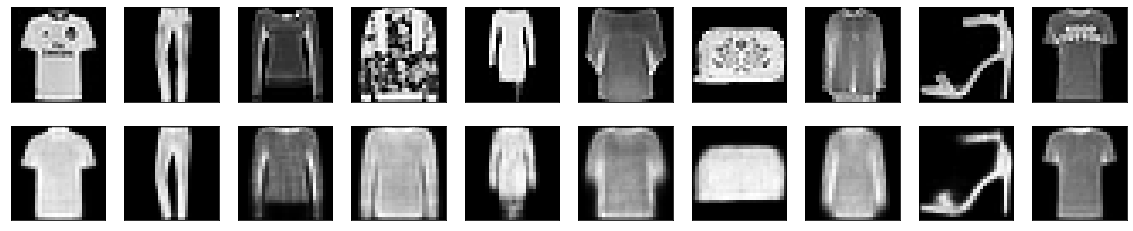

In [29]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
K.mean(tf.keras.losses.binary_crossentropy(X_test, decoded_imgs))

<tf.Tensor: shape=(), dtype=float32, numpy=0.28304893>

In [ ]:
from sklearn.manifold import TSNE